In [29]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=False)
from pathlib import Path

from core.utils import *

In [4]:
pkl_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new'
pkl_path = Path(pkl_path)

In [12]:
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'

In [13]:
reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]

In [20]:
SFs = joblib.load(nominal_path / nominal_keys[0] / "SFs.pkl") # this includes many vars with WPs 


In [22]:
SFs[reweighting_vars[0]][0.5]

{'Quark': array([1.0279333381553586+/-0.0018586113195646565,
        1.0443329347783434+/-0.0015922765556675275,
        1.0461937516008866+/-0.0028960158934784102,
        1.033476695908774+/-0.005694787038356356,
        1.0204495764454495+/-0.010449997703414317,
        1.00974996065689+/-0.02274082580019074], dtype=object),
 'Gluon': array([0.9976396644241626+/-0.0015426248605250306,
        0.9918263566430869+/-0.0015110416048499872,
        0.9835812581791289+/-0.003159745227864179,
        0.9650002946311069+/-0.0070948285520520075,
        0.944176894562725+/-0.014411382245602048,
        0.9246181658202915+/-0.0404637170522422], dtype=object)}

In [23]:
syst_type = 'trk_eff'
syst_subtype = 'jet_nTracks_sys_fake'


In [26]:
syst_path = pkl_path / syst_type / syst_subtype / 'plots' / 'ADE' / 'SFs_pkls'
syst_SFs = joblib.load(syst_path / nominal_keys[0] / "SFs.pkl") # this includes many vars with WPs 

In [36]:
syst_SFs[reweighting_vars[0]][0.5]["Quark"] - SFs[reweighting_vars[0]][0.5]["Quark"]

array([-0.06588015325100471+/-0.0026238200060595823,
       -0.06015822413290628+/-0.0022553927738627856,
       -0.054401339266425985+/-0.004114956362973315,
       -0.04645620952195939+/-0.00809487032140833,
       -0.04178067158998555+/-0.01479547991192848,
       -0.0344438428944277+/-0.032109604833083685], dtype=object)

In [38]:
unumpy.nominal_values(syst_SFs[reweighting_vars[0]][0.5]["Quark"] - SFs[reweighting_vars[0]][0.5]["Quark"])

array([-0.06588015, -0.06015822, -0.05440134, -0.04645621, -0.04178067,
       -0.03444384])

In [37]:
syst_SFs[reweighting_vars[0]][0.5]["Gluon"] - SFs[reweighting_vars[0]][0.5]["Gluon"]

array([-0.013376082115463928+/-0.002244037908975752,
       -0.014983024894457464+/-0.0021970545412884125,
       -0.016243112505119117+/-0.0045913602697837804,
       -0.015249732769596736+/-0.010290546416806998,
       -0.014529552083080821+/-0.02079933309435147,
       -0.011723179706489284+/-0.05806613717916499], dtype=object)

In [91]:
syst_config ={
    # "nominal": {

    # },
    "trk_eff": {
        "has_subtype": True,
        "syst_subtype": trk_eff_uncertainties,
        "handle": 'quadratic',
    },
    "JESJER": {
        "has_subtype": True,
        "syst_subtype": JESJER_uncertainties,
        "handle": 'quadratic',
    }
}

In [101]:
WPs = [0.5, 0.6, 0.7, 0.8]
for i_var, reweighting_var in enumerate(reweighting_vars[:1]):
    nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'SFs_pkls'
    nominal_SFs = joblib.load(nominal_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 

    syst_total = dict.fromkeys(syst_config.keys())
    for syst_type, value in syst_config.items():
        # Doing one syst 
        syst_total[syst_type] = syst_total.fromkeys(WPs)
        if value['has_subtype']:
            syst_sub_var = dict.fromkeys(value['syst_subtype'])
            
            for syst_subtype in value['syst_subtype']:
                syst_sub_var[syst_subtype] = dict.fromkeys(WPs)
                syst_path = pkl_path / syst_type / syst_subtype / 'plots' / 'ADE' / 'SFs_pkls'
                syst_SFs = joblib.load(syst_path / nominal_keys[i_var] / "SFs.pkl") # this includes many vars with WPs 
                for WP in WPs:
                    syst_sub_var[syst_subtype][WP] = {
                        "Quark":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Quark"] \
                                                       - syst_SFs[reweighting_var][WP]["Quark"]),
                        "Gluon":unumpy.nominal_values(nominal_SFs[reweighting_var][WP]["Gluon"] \
                                                       - syst_SFs[reweighting_var][WP]["Gluon"]),                                                       
                    } 
        
            if value['handle'] == 'quadratic':
                for WP in WPs:
                    syst_total[syst_type][WP] = {
                        "Quark" : np.zeros(len(label_pt_bin) - 1),
                        "Gluon" : np.zeros(len(label_pt_bin) - 1),
                    }
                for syst_subtype in value['syst_subtype']:
                    for WP in WPs:
                        for parton in ['Quark', 'Gluon']:
                            syst_total[syst_type][WP][parton] += np.power(syst_sub_var[syst_subtype][WP][parton], 2)

                for WP in WPs:
                    for parton in ['Quark', 'Gluon']:
                        syst_total[syst_type][WP][parton] = np.sqrt(syst_total[syst_type][WP][parton])
            
            if value['handle'] == 'envelope':
                
                for WP in WPs:
                    syst_total[syst_type][WP] = dict.fromkeys(['Quark', 'Gluon'])

                    for parton in ['Quark', 'Gluon']:
                        syst_subtype_var = []
                        for syst_subtype in value['syst_subtype']:
                            syst_subtype_var.append(syst_total[syst_type][WP][parton])
                        syst_subtype_var = np.array(syst_subtype_var) # should be (num of subtypes, 6)
                        syst_total[syst_type][WP][parton] = np.max(np.abs(syst_subtype_var), axis=0) # the max along columns

    # for WP in WPs:
    #     fig, ax = plt.subplots()
        

        

In [99]:
syst_total

{'trk_eff': {0.5: {'Quark': array([0.07838215, 0.07105041, 0.06370761, 0.05383175, 0.04803941,
          0.0399023 ]),
   'Gluon': array([0.0148738 , 0.0165012 , 0.01774697, 0.01621967, 0.01536355,
          0.0123203 ])},
  0.6: {'Quark': array([0.07708517, 0.06749625, 0.05893219, 0.0517522 , 0.0453059 ,
          0.03591566]),
   'Gluon': array([0.01551961, 0.01638574, 0.01658754, 0.01688472, 0.01609701,
          0.00952872])},
  0.7: {'Quark': array([0.07454819, 0.06302027, 0.05462789, 0.0473304 , 0.03943486,
          0.03287973]),
   'Gluon': array([0.01548032, 0.01524581, 0.01551349, 0.01537917, 0.01325577,
          0.01323624])},
  0.8: {'Quark': array([0.06427668, 0.05343191, 0.04594418, 0.03787851, 0.03049519,
          0.02480305]),
   'Gluon': array([0.01061766, 0.01012699, 0.01076818, 0.01094601, 0.00763662,
          0.00500626])}},
 'JESJER': {0.5: {'Quark': array([0.00378759, 0.00372336, 0.00398474, 0.00371144, 0.00395397,
          0.0026049 ]),
   'Gluon': array([0.0

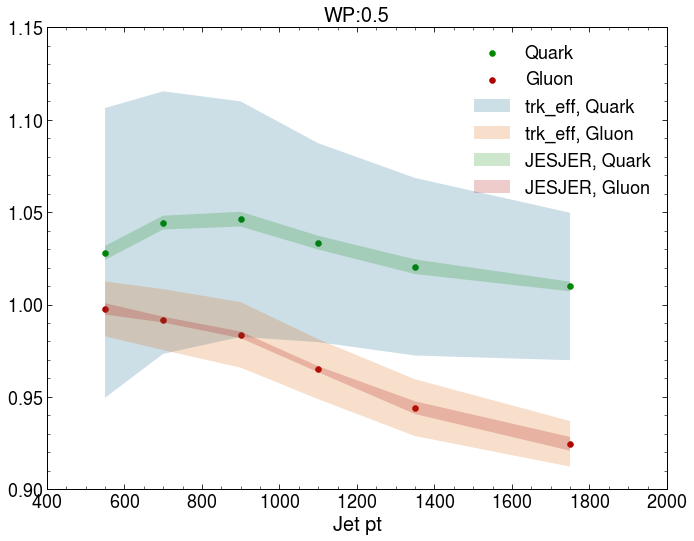

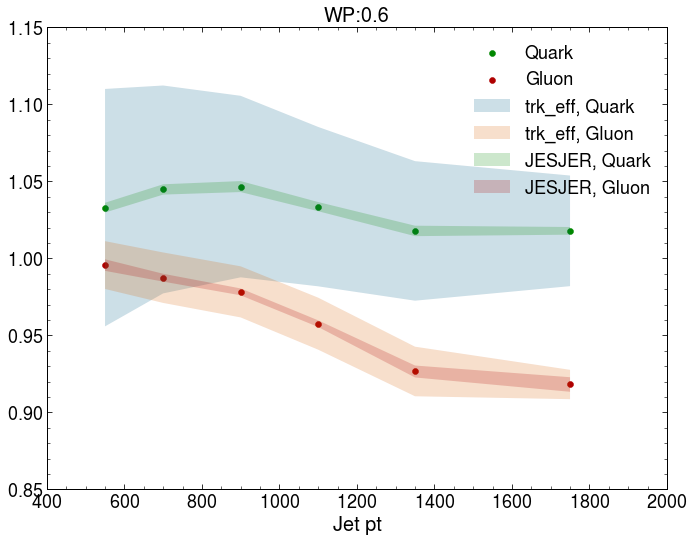

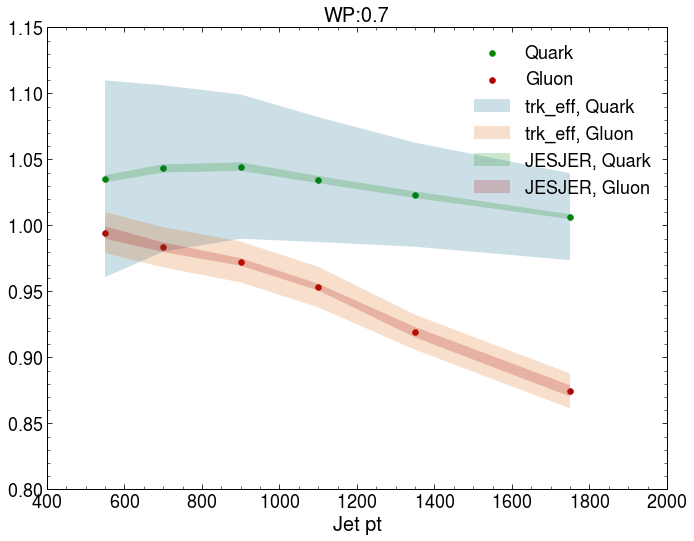

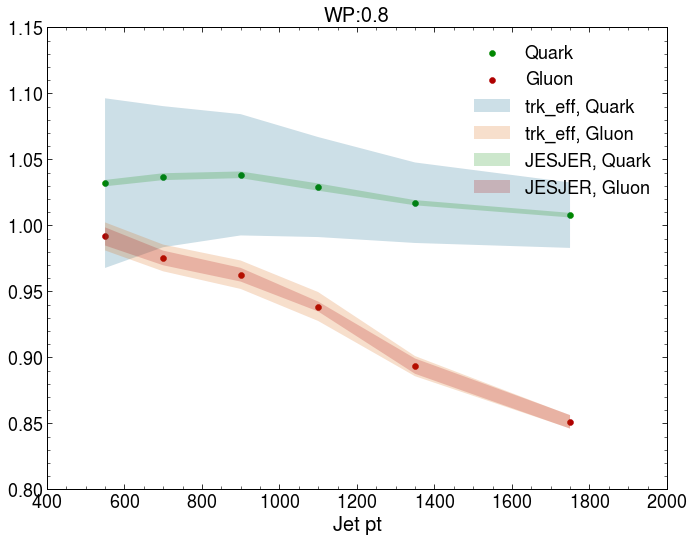

In [102]:
bin_centers = 0.5 * (np.array(label_pt_bin[:-1]) + np.array(label_pt_bin[1:]))

for WP in WPs:
    fig, ax = plt.subplots()
    quark_nominal_values = unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Quark'])
    gluon_nominal_values = unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Gluon'])
    ax.scatter(bin_centers, quark_nominal_values, label = "Quark")
    ax.scatter(bin_centers, gluon_nominal_values, label = "Gluon")

    for key in syst_total.keys():
        quark_uncertainty = syst_total[key][WP]['Quark']
        ax.fill_between(bin_centers, quark_nominal_values-quark_uncertainty, quark_nominal_values+quark_uncertainty, \
                        # color='b',
                        alpha=0.2, label=f'{key}, Quark')

        gluon_uncertainty = syst_total[key][WP]['Gluon']
        ax.fill_between(bin_centers, gluon_nominal_values-gluon_uncertainty, gluon_nominal_values+gluon_uncertainty, \
                        # color='r', 
                        alpha=0.2, label=f'{key}, Gluon')
    # ax.scatter(bin_centers, unumpy.nominal_values(nominal_SFs['jet_nTracks'][WP]['Gluon']), label = "Gluon")
    ax.set_title(f"WP:{WP}")
    ax.set_xlabel("Jet pt")
    ax.legend()



In [85]:
nominal_SFs['jet_nTracks']

{0.5: {'Quark': array([1.0279333381553586+/-0.0018586113195646565,
         1.0443329347783434+/-0.0015922765556675275,
         1.0461937516008866+/-0.0028960158934784102,
         1.033476695908774+/-0.005694787038356356,
         1.0204495764454495+/-0.010449997703414317,
         1.00974996065689+/-0.02274082580019074], dtype=object),
  'Gluon': array([0.9976396644241626+/-0.0015426248605250306,
         0.9918263566430869+/-0.0015110416048499872,
         0.9835812581791289+/-0.003159745227864179,
         0.9650002946311069+/-0.0070948285520520075,
         0.944176894562725+/-0.014411382245602048,
         0.9246181658202915+/-0.0404637170522422], dtype=object)},
 0.6: {'Quark': array([1.0328955737461314+/-0.001750771722367234,
         1.044722955032124+/-0.0014986834173378503,
         1.0465884898001971+/-0.0027266553307359557,
         1.0335629015160124+/-0.005372809554784582,
         1.017783118505041+/-0.009751816323492205,
         1.01783619174369+/-0.02139744215277465

In [55]:
0.04 **2 + 0.06**2

0.0052

In [56]:
syst_sub_var['jet_nTracks_sys_eff'][0.5]['Quark']

array([0.04246842, 0.03780408, 0.03315349, 0.02719702, 0.02370992,
       0.02014486])

In [58]:
syst_sub_var['jet_nTracks_sys_eff'][0.5]['Quark'] ** 2 + syst_sub_var['jet_nTracks_sys_fake'][0.5]['Quark'] **2

array([0.00614376, 0.00504816, 0.00405866, 0.00289786, 0.00230778,
       0.00159219])

In [57]:
syst_sub_var['jet_nTracks_sys_fake'][0.5]['Quark']

array([0.06588015, 0.06015822, 0.05440134, 0.04645621, 0.04178067,
       0.03444384])

In [96]:
syst_total['trk_eff'][0.5]['Quark'] ** 2

array([0.00614376, 0.00504816, 0.00405866, 0.00289786, 0.00230778,
       0.00159219])